In [2]:
import os
import torch
import torch.nn as nn
import numpy as np

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim import Adam

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
DATASET_DIR = r"C:\Users\Hp\Desktop\Project\datasetResNet"   # CHANGE THIS


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [6]:
train_dataset = datasets.ImageFolder(
    os.path.join(DATASET_DIR, "train"),
    transform=transform
)

val_dataset = datasets.ImageFolder(
    os.path.join(DATASET_DIR, "valid"),
    transform=transform
)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)


Classes: ['Biodegradable', 'Hazardous', 'NonBiodegradable']


In [7]:
resnet = models.resnet50(pretrained=True)

# Replace classifier
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

resnet = resnet.to(device)
print(resnet.fc)


c:\Users\Hp\Desktop\Project\edge_ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hp\Desktop\Project\edge_ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2048, out_features=3, bias=True)


In [8]:
criterion = nn.CrossEntropyLoss()

optimizer = Adam(
    resnet.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)


In [9]:
EPOCHS = 30

train_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # ---- TRAIN ----
    resnet.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # ---- VALIDATE ----
    resnet.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = resnet(images)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_accuracies.append(val_acc)

    print(f"Train Loss: {avg_loss:.4f}")
    print(f"Val Accuracy: {val_acc:.4f}")



Epoch 1/30
Train Loss: 0.2782
Val Accuracy: 0.9570

Epoch 2/30
Train Loss: 0.1576
Val Accuracy: 0.9597

Epoch 3/30
Train Loss: 0.1037
Val Accuracy: 0.9570

Epoch 4/30
Train Loss: 0.0956
Val Accuracy: 0.9676

Epoch 5/30
Train Loss: 0.0827
Val Accuracy: 0.9656

Epoch 6/30
Train Loss: 0.0611
Val Accuracy: 0.9649

Epoch 7/30
Train Loss: 0.0693
Val Accuracy: 0.9702

Epoch 8/30
Train Loss: 0.0416
Val Accuracy: 0.9636

Epoch 9/30
Train Loss: 0.0532
Val Accuracy: 0.9663

Epoch 10/30
Train Loss: 0.0613
Val Accuracy: 0.9385

Epoch 11/30
Train Loss: 0.0586
Val Accuracy: 0.9649

Epoch 12/30
Train Loss: 0.0405
Val Accuracy: 0.9742

Epoch 13/30
Train Loss: 0.0512
Val Accuracy: 0.9616

Epoch 14/30
Train Loss: 0.0332
Val Accuracy: 0.9570

Epoch 15/30
Train Loss: 0.0350
Val Accuracy: 0.9669

Epoch 16/30
Train Loss: 0.0215
Val Accuracy: 0.9511

Epoch 17/30
Train Loss: 0.0830
Val Accuracy: 0.9597

Epoch 18/30
Train Loss: 0.0273
Val Accuracy: 0.9458

Epoch 19/30
Train Loss: 0.0223
Val Accuracy: 0.9676

E

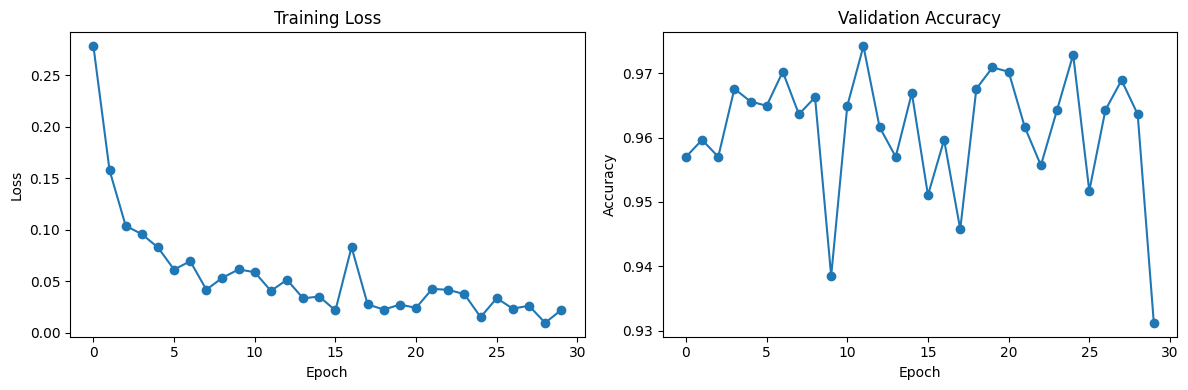

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(val_accuracies, marker='o')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [11]:
all_preds = []
all_labels = []

resnet.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(
    all_labels,
    all_preds,
    target_names=train_dataset.classes,
    digits=4
))


                  precision    recall  f1-score   support

   Biodegradable     0.9605    0.8382    0.8952       377
       Hazardous     0.9664    0.9686    0.9675       446
NonBiodegradable     0.9035    0.9652    0.9333       689

        accuracy                         0.9345      1512
       macro avg     0.9435    0.9240    0.9320      1512
    weighted avg     0.9363    0.9345    0.9339      1512



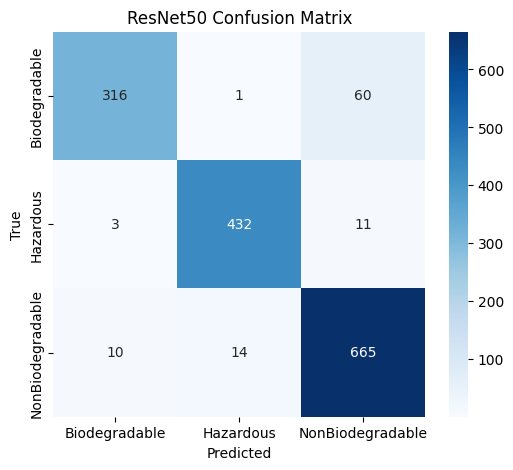

In [12]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=train_dataset.classes,
    yticklabels=train_dataset.classes
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ResNet50 Confusion Matrix")
plt.show()


In [13]:
torch.save(resnet.state_dict(), "resnet50_waste_classifier.pth")
print("Saved PyTorch model")


Saved PyTorch model


In [14]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)

onnx_path = "resnet50_waste_classifier.onnx"

torch.onnx.export(
    resnet,
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes={
        "input": {0: "batch_size"},
        "logits": {0: "batch_size"}
    },
    opset_version=14
)

print("ONNX model exported:", onnx_path)


ONNX model exported: resnet50_waste_classifier.onnx
